In [1]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
from bw_temporalis import easy_timedelta_distribution, TemporalisLCA

In [5]:
bd.projects.set_current('tictac2')

In [6]:
bd.databases

Databases dictionary with 0 objects

In [7]:
del bd.databases['wind-example']

KeyError: 'wind-example'

In [8]:
bd.databases

Databases dictionary with 0 objects

In [9]:
generated_electricity_over_lifetime = 4.38e9 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.5
LT = 25 # 25 years lifetime of a wind turbine

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind = 'triangular',
                    param = -1
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'normal',
                    param = 0.1
                )
            },
            # aggregate the rest to direct co2 emissions
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 50994.58it/s]

Vacuuming database 


In [10]:
import bw_temporalis as bwt

<Axes: xlabel='Time (seconds)', ylabel='Amount'>

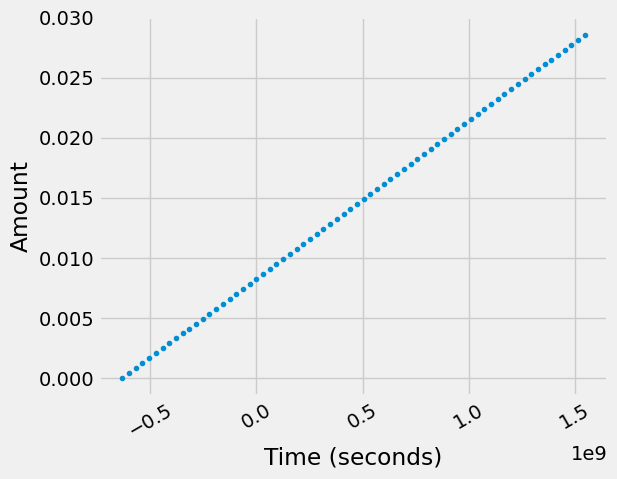

In [11]:
td = easy_timedelta_distribution(
                    start=-20,
                    end=49,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=70,
                    kind = 'triangular',
                    param = 49
                )
td.graph()

In [12]:
bd.databases

Databases dictionary with 1 object(s):
	wind-example

In [13]:
bd.Method(("GWP", "wind-example")).write([
    (('wind-example', "CO2"), 1),
])

In [14]:
lca = bc.LCA({('wind-example', 'electricity-production-wind'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

0.0002819731177506934

In [15]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 7


In [16]:
tl = tlca.build_timeline()

In [17]:
import seaborn as sb
import pandas as pd

In [18]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [19]:
# df

In [20]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

In [21]:
# df2

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by 1WT')

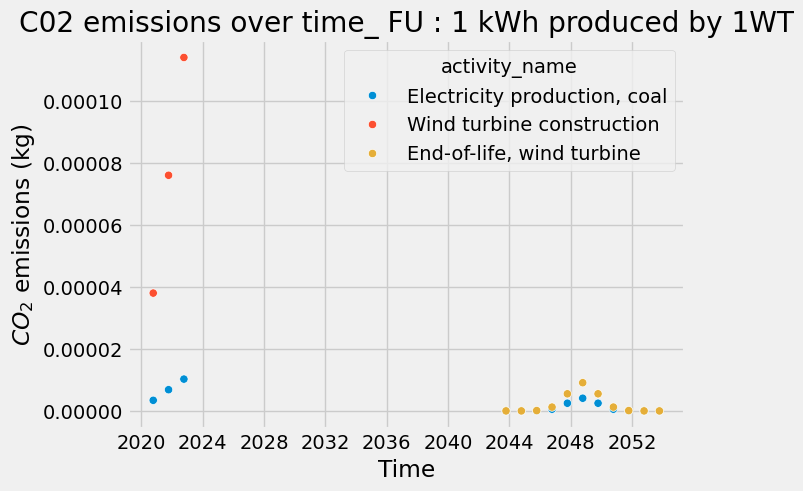

In [24]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by 1WT") #right after being put in service